# Label 분포 EDA

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import re
from tqdm import tqdm
tqdm.pandas()
train_path = '/root/klue_ner/data/klue_ner_train_80.csv'
test_path = '/root/klue_ner/data/klue_ner_test_20.csv'

In [2]:
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

In [3]:
train_df.sentence[10212] = train_df.sentence[10212].replace('일녀<QT>', '<일녀:QT>')

In [4]:
from typing import Tuple
from copy import deepcopy

def find_all_label(sentence: str) -> Tuple[np.array, np.array]:
    # <aa:PS> 형태의 문자열 리스트 추출
    sentence = re.findall( r'<.*?\:.*?>', sentence)
    # '<', '>' 제거
    sentence = [i.replace('<','') for i in sentence]
    sentence = [i.replace('>','') for i in sentence]
    # : 를 기준으로 name, entity 리스트로 분리
    before_split = deepcopy(sentence)
    sentence = [i.split(':') for i in sentence]
    sentence_array = np.array(sentence)
    # 0번째 리스트는 name 리스트로, name만 array로 만듦
    ner_array = sentence_array[...,0]
    # 1번째 리스트는 label 리스트로, label만 array 만듦
    label_array = sentence_array[...,1]
    # 튜플 형태로 반환
    return before_split, ner_array, label_array

def remove_label(sentence: str) -> str:
    sentence = re.sub(r':.*?>','', sentence)
    sentence = re.sub(r'<','',sentence)
    sentence = re.sub(r'[^가-힣a-zA-Z0-9.%~]',' ' ,sentence)
    sentence = re.sub('[ ]+',' ',sentence)
    sentence = sentence.strip()
    return sentence

In [5]:
train_df['labels'] = train_df.sentence.apply(find_all_label)
train_df['train_label'] = train_df.labels.apply(lambda x: x[0])
train_df['name'] = train_df.labels.apply(lambda x: x[1])
train_df['entity'] = train_df.labels.apply(lambda x: x[2])
train_df['org_sentence'] = train_df.sentence.apply(remove_label)

test_df['labels'] = test_df.sentence.apply(find_all_label)
test_df['train_label'] = test_df.labels.apply(lambda x: x[0])
test_df['name'] = test_df.labels.apply(lambda x: x[1])
test_df['entity'] = test_df.labels.apply(lambda x: x[2])
test_df['org_sentence'] = test_df.sentence.apply(remove_label)

카테고리  
person(PS),  
location(LC),   
organization(OG),  
date(DT),  
time(TI),  
quantity(QT)

## Train data 전체 label 갯수

In [6]:
train_label_list = np.array([])
for i in tqdm(train_df.itertuples()):
    train_label_list = np.concatenate([train_label_list, i.entity])
train_unique, train_count = np.unique(train_label_list, return_counts=True)
train_label_count = dict(zip(train_unique, train_count))
train_label_count

20802it [00:35, 587.60it/s] 


{'DT': 8246, 'LC': 6701, 'OG': 8549, 'PS': 15114, 'QT': 11891, 'TI': 2062}

## bar Chart

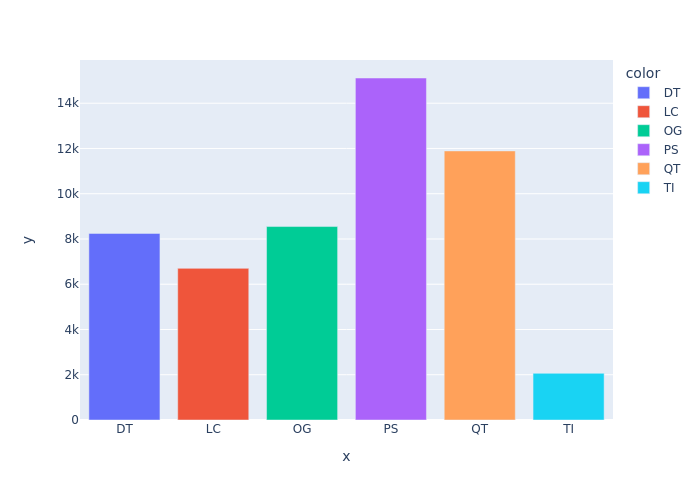

In [8]:
from IPython.display import Image
fig = px.bar( x=train_label_count.keys(), y=train_label_count.values(), color=train_label_count.keys())
Image(fig.to_image())

## Pie chart

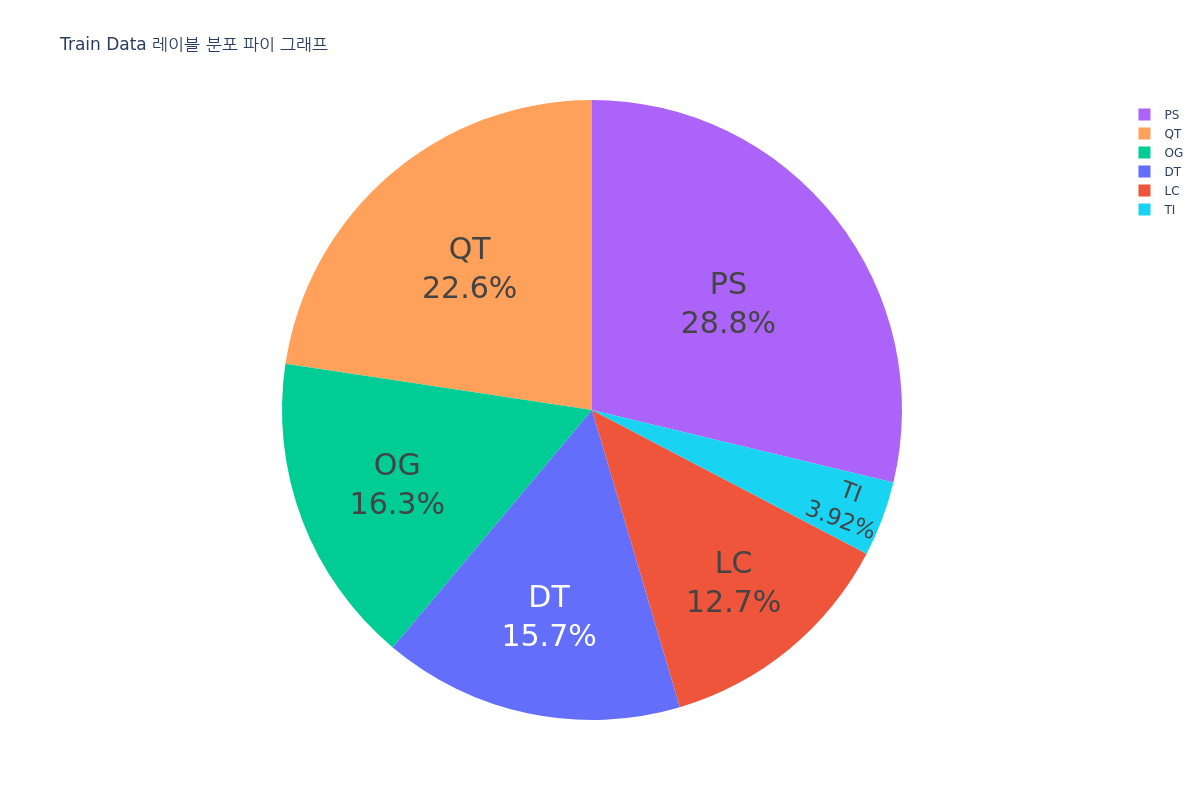

In [9]:
fig = px.pie( names=train_label_count.keys(), values=train_label_count.values(), color=train_label_count.keys(), 
       width=1200, height=800, title='Train Data 레이블 분포 파이 그래프')
fig.update_traces(textposition='inside', textinfo='percent+label', textfont_size=30)
fig.update_layout(uniformtext_minsize=12,)
Image(fig.to_image())

## Test data 레이블 분포 확인

In [10]:
test_label_list = np.array([])
for i in tqdm(test_df.itertuples()):
    test_label_list = np.concatenate([test_label_list, i.entity])
test_unique, test_count = np.unique(test_label_list, return_counts=True)
test_label_count = dict(zip(test_unique, test_count))
test_label_count

5201it [00:00, 7871.30it/s] 


{'DT': 2095, 'LC': 1613, 'OG': 2125, 'PS': 3757, 'QT': 2982, 'TI': 504}

## Bar chart

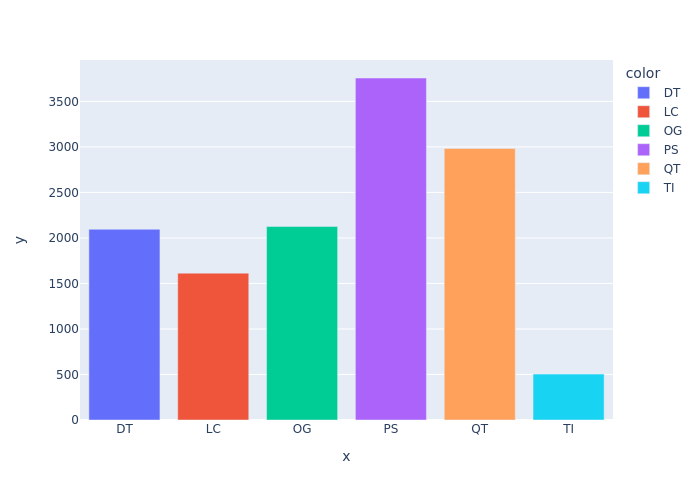

In [11]:
fig = px.bar( x=test_label_count.keys(), y=test_label_count.values(), color=test_label_count.keys())
Image(fig.to_image())

## Pie chart

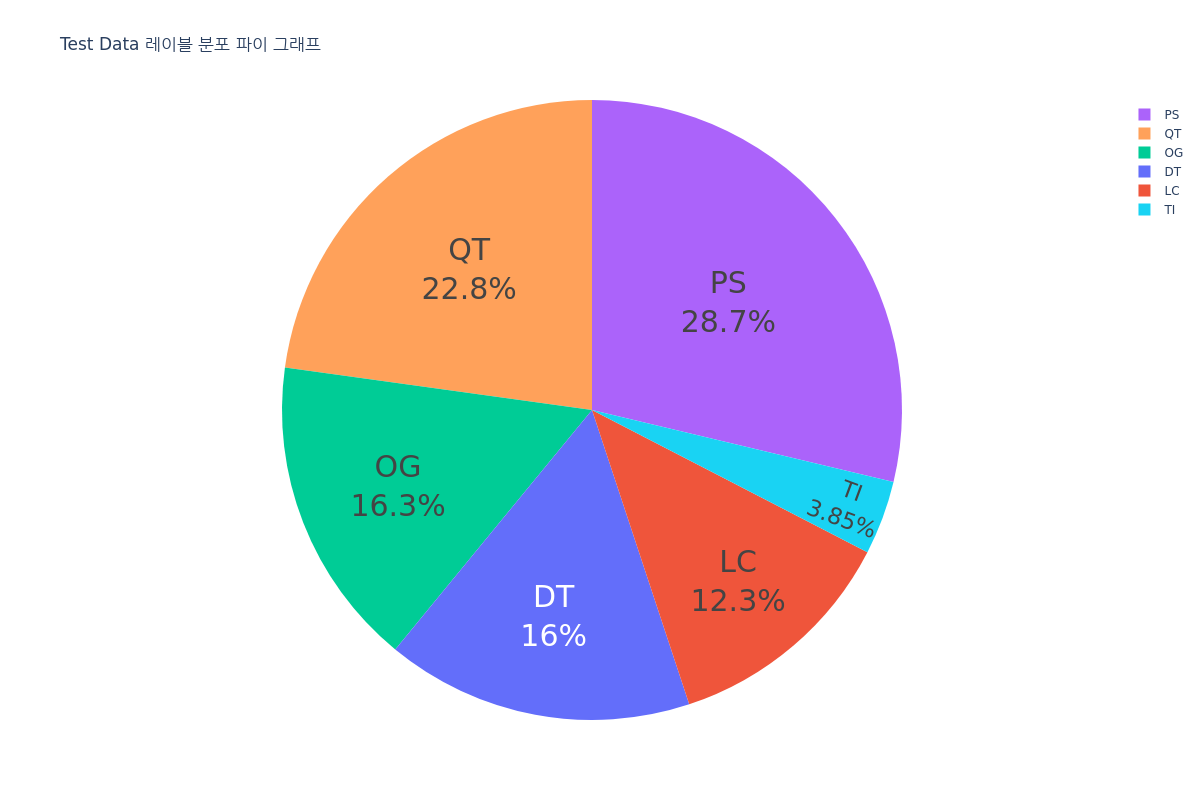

In [12]:
fig = px.pie( names=test_label_count.keys(), values=test_label_count.values(), color=test_label_count.keys(), 
       width=1200, height=800, title='Test Data 레이블 분포 파이 그래프')
fig.update_traces(textposition='inside', textinfo='percent+label', textfont_size=30)
fig.update_layout(uniformtext_minsize=12,)
Image(fig.to_image())

In [14]:
train_ratio = dict(zip(train_unique, np.round(((train_count / train_count.sum()) * 100),2)))
test_ratio = dict(zip(test_unique, np.round(((test_count / test_count.sum()) * 100),2)))

In [20]:
np.array(list(train_ratio.values()))

array([15.69, 12.75, 16.26, 28.75, 22.62,  3.92])

In [44]:
np.round((np.array(list(train_ratio.values())) + np.array(list(test_ratio.values()))) / 2,0)

array([16., 13., 16., 29., 23.,  4.])

In [46]:
sum([16,13,16,28,23,4])

100

Test 데이터가 우리가 예측해야할 대상의 분포이고, Train 데이터의 분포가 Test 데이터와 비슷한 형태의 분포를  
띄고 있으므로, 현재 예측 하는 형태 대로 학습시키고, Validation 한다면 결과에 좋은 영향을 줄 수 있을 것.